# Single Subject First Level Models

(originally written by Luke Change, expanded by Tom Yeh)

The first step in fMRI data analysis is to build a model for each subject to predict the activation in a single voxel over the entire scanning session. To do this, we need to build a design matrix for our general linear model. We expect distinct brain regions to be involved in processing specific aspects of our task. This means that we will construct separate regressors that model different brain processes. Here we will load a pre-made design matrix with the onsets of each trial from the Pinel Localizer task. 

The Pinel Localizer task was designed to probe several different types of basic cognitive processes, such as visual perception, finger tapping, language, and math. Several of the tasks are cued by reading text on the screen (i.e., visual modality) and also by hearing auditory instructions (i.e., auditory modality). The trials are randomized across conditions and have been optimized to maximize efficiency for a rapid event related design. There are 100 trials in total over a 5-minute scanning session. Read the [paper](https://bmcneurosci.biomedcentral.com/articles/10.1186/1471-2202-8-91) for more specific details about the task. You can also view the Data on the author's [cubicweb](http://brainomics.cea.fr/localizer/dataset?rql=Any%20X%2C%20XT%2C%20XL%2C%20XI%2C%20XF%2C%20XD%20WHERE%20X%20is%20Scan%2C%20X%20type%20XT%2C%20X%20label%20XL%2C%20X%20identifier%20XI%2C%20X%20format%20XF%2C%20X%20description%20XD) interface.

I encourage you to watch some short introductory videos on the GLM by Tor Wager and Martin Lindquist.
 - [GLM Applied to fMRI](https://www.youtube.com/watch?v=OyLKMb9FNhg&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=19)
 - [Conditions & Contrasts](https://www.youtube.com/watch?v=7MibM1ATai4&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=20)
 - [Temporal Basis Sets](https://www.youtube.com/watch?v=YfeMIcDWwko&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=21)
 - [Nuisance Variables](https://www.youtube.com/watch?v=DEtwsFdFwYc&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=22)
 - [Inference/Contrasts/T-Tests ](https://www.youtube.com/watch?v=NRunOo7EKD8&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=25)
 
Let's first load all of the python modules we will need to complete this tutorial. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Study Design

Here is the data representing the design the Localizer task, obtained from the research group's website.
http://www.neurospin-wiki.org/pmwiki/Main/StandardLocalizers?action=download&upname=Timing.m

In [2]:
# (seconds)
total_scan_time = 300 # five minutes

# (milliseconds)
onset_times = [0,2400,5700,8700,11400,15000,18000,20700,23700,26700,29700,33000,35400,39000,41700,44700,48000,
        50700,53700,56400,59700,62400,66000,69000,71400,75000,78000,80400,83400,87000,89700,93000,96000,
        99000,102000,105000,108000,110400,113700,116700,119400,122700,125400,129000,131400,135000,137700,
        140400,143400,146700,149400,153000,156000,159000,162000,164400,167700,170400,173700,176700,179700,
        182700,186000,188400,191700,195000,198000,201000,203700,207000,210000,212700,215700,218700,221400,
        224700,227700,230700,234000,236700,240000,243000,246000,248400,251700,254700,257400,260400,264000,
        266700,269700,272700,275400,278400,281700,284400,288000,291000,293400,296700]

# onset type (one-based index)
onset_types = [8,8,11,1,3,10,5,10,4,6,10,2,7,9,9,7,7,11,11,9,
        1,4,11,5,6,9,11,11,7,3,10,11,2,11,11,11,7,11,11,6,
        10,2,8,11,9,7,7,2,3,10,1,8,2,9,3,8,9,4,7,1,
        11,11,11,1,7,9,8,8,2,2,2,6,6,1,8,1,5,3,8,10,
        11,11,9,1,7,4,4,8,2,1,1,11,5,2,11,10,9,5,10,10]

localizer_labels = ['horizontal_checkerboard',
          'vertical_checkerboard',
          'motor_right_auditory',          
          'motor_left_auditory',
          'motor_right_visual',          
          'motor_left_visual',
          'subtraction_auditory',
          'subtraction_visual',          
          'sentence_visual',   
          'sentence_auditory']


Let's create a wrapper function to make it easy to obtain the data about the task design. We want to represent the task as a list of events, where each event is a tupple of onset time (ms) and onset type (from 0 to 9). The function also returns a list of labels for the 10 onset types.

In [3]:
def get_localizer_design_data():

    # onset type
    onset_types_0_based = np.array(onset_types) - 1
    
    events = list(zip(onset_times, onset_types_0_based))
    
    # ignore the last onset type
    events = [(onset_time, onset_type) for (onset_time, onset_type) in events if onset_type != 10]
    
    return (events, localizer_labels)

events, labels = get_localizer_design_data()
events[0:5]

[(0, 7), (2400, 7), (8700, 0), (11400, 2), (15000, 9)]

## Design Matrix

First, we want to create a design matrix to represent the task. Each event type can be represented as a time series or a vector. Let's write a function to derive a vector for a particular event type, where each element in the vector corresponds to a time slice `tr` and the length of the vector is the number of time slices `n_tr`.

In [4]:
def compute_design_vector(events, event_index, n_tr, tr):
    
    selected_onset_times = [onset_time for onset_time, onset_type in events if onset_type == event_index]
        
    iss = np.floor(np.array(selected_onset_times) / (tr * 1000)).astype(int)
                           
    line = np.zeros(n_tr)
        
    line[iss] = 1
    
    return line

In [5]:
events, labels = get_localizer_design_data()
events
labels

['horizontal_checkerboard',
 'vertical_checkerboard',
 'motor_right_auditory',
 'motor_left_auditory',
 'motor_right_visual',
 'motor_left_visual',
 'subtraction_auditory',
 'subtraction_visual',
 'sentence_visual',
 'sentence_auditory']

Let's compute the vector for event 8 and plot it.

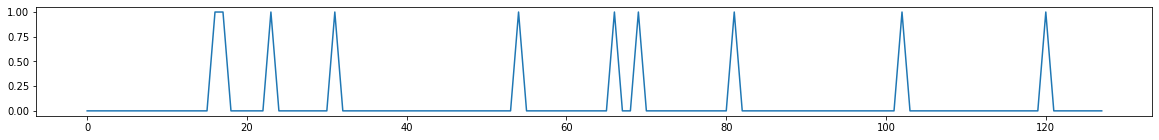

In [6]:
design_vector_8 = compute_design_vector(events, 8, 128, 2.4)
plt.figure(figsize=(20,2))
plt.plot(design_vector_8)

Let's try event 6.

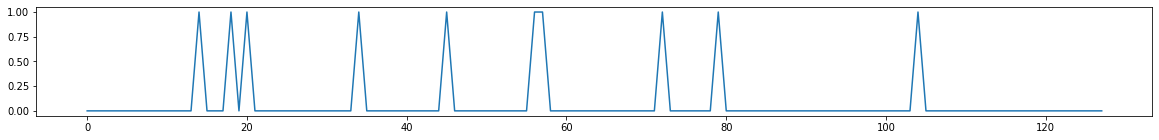

In [7]:
design_vector_6 = compute_design_vector(events, 6, 128, 2.4)
plt.figure(figsize=(20,2))
plt.plot(design_vector_6)

Now, to derive a design matrix, we simply stack all the vectors vertically. Each vector is a column. The number of columns should be the number of event types, which is 11 in this case. The numebr of rows should be the number of slices or `n_tr`, which is 128.

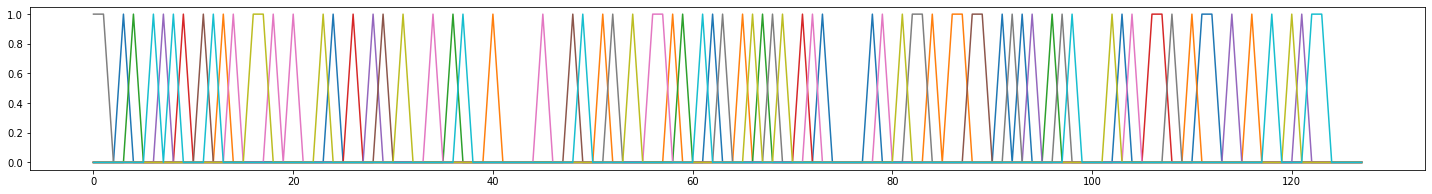

In [8]:
design_matrix = np.zeros((128, 10),int)
for i in range(0, len(labels)):
    design_vector_i = compute_design_vector(events, i, 128, 2.4)
    design_matrix[:,i] = design_vector_i.T
    
plt.figure(figsize=(25,3))
plt.plot(design_matrix);

One way to visualize a design matrix is to plot them vertically, where each time series goes downard vertically just like how it is represented in a vertical column. 

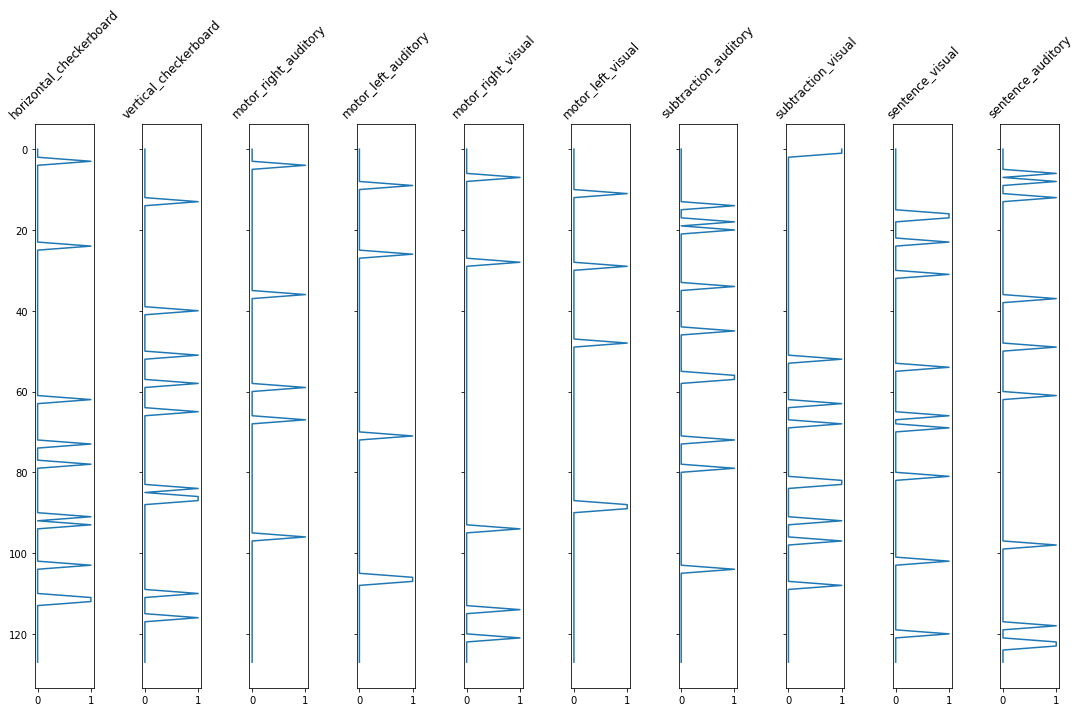

In [9]:
def plot_design_matrix(X, labels):
    m = len(labels)
    f, a = plt.subplots(ncols=m, figsize=(m*1.5, 10), sharey=True)
    times = range(X.shape[0])
    
    for i in range(0, m):        
        label = labels[i]
        a[i].plot(X[:,i], times)
        a[i].set_title(label, fontsize=12, rotation=45)

    plt.gca().invert_yaxis()
    plt.tight_layout()

plot_design_matrix(design_matrix, labels)

## HRF Convolution
Recall what we learned about convolution in our signal processing tutorial. We can convolve all of the onset regressors with an HRF function.

/Users/hanxu/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Text(0.5, 0, 'Time')

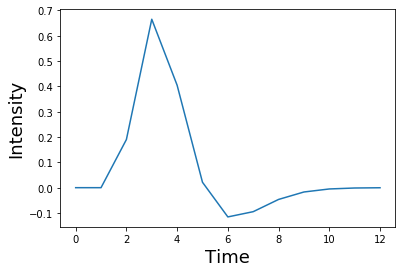

In [10]:
from nltools.external import glover_hrf

tr = 2.4
hrf = glover_hrf(tr, oversampling=1)

plt.plot(hrf)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

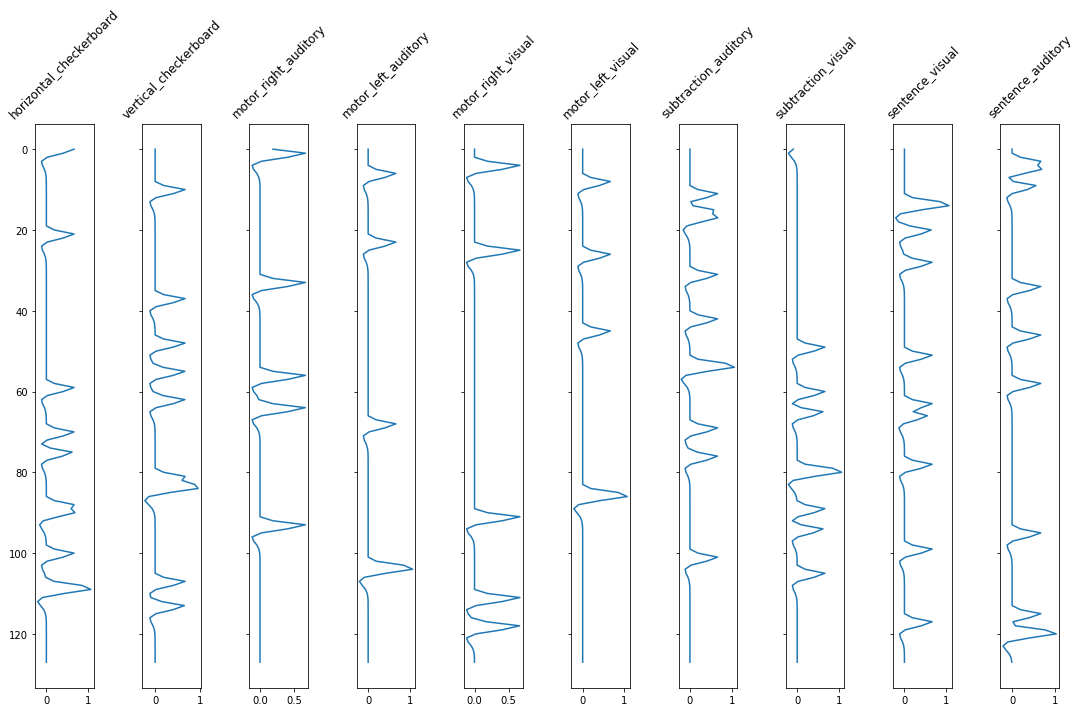

In [11]:
design_matrix_hrf = np.zeros(design_matrix.shape,float)
for i in range(0, design_matrix.shape[1]):
    design_matrix_hrf[:,i] = np.convolve(design_matrix[:,i], hrf, mode='same')
    
plot_design_matrix(design_matrix_hrf, labels)

## Filtering
Recall from our signal processing tutorial, that there are often other types of artifacts in our signal that might take the form of slow or fast oscillations. It is common to apply a high pass filter to the data to remove low frequency artifacts. Often this can also be addressed by simply using a few polynomials to model these types of trends. If we were to directly filter the brain data using something like a butterworth filter as we did in our signal processing tutorial, we would also need to apply it to our design matrix to make sure that we don't have any low frequency drift in experimental design. One easy way to simultaneously perform both of these procedures is to simply build a filter into the design matrix. We will be using a discrete cosine transform (DCT), which is a basis set of cosine regressors of varying frequencies up to a filter cutoff of a specified number of seconds.

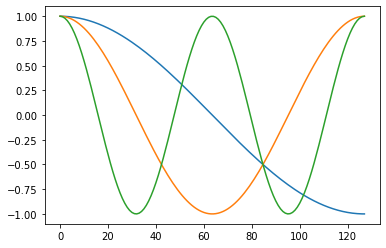

In [12]:
from numpy import sin, cos, pi, arange
def generate_cosine_wave(duration, freq, amplitude, phase = 0):
    time = np.linspace(0, 1, duration)
    return amplitude * cos(2*pi*freq*time + pi*phase)

plt.plot(generate_cosine_wave(128, 0.5, 1))
plt.plot(generate_cosine_wave(128, 1, 1))
plt.plot(generate_cosine_wave(128, 2, 1));

Let's add a few consine waves to our design matrix, simply by appending them as additional columns.

In [13]:
cos1 = generate_cosine_wave(128, 0.5, 1)
cos2 = generate_cosine_wave(128, 1, 1)
cos3 = generate_cosine_wave(128, 2, 1)

coss = np.array([cos1, cos2, cos3]).T # => (128, 3)

design_matrix_cos = np.hstack([design_matrix_hrf, coss])
design_matrix_cos.shape

(128, 13)

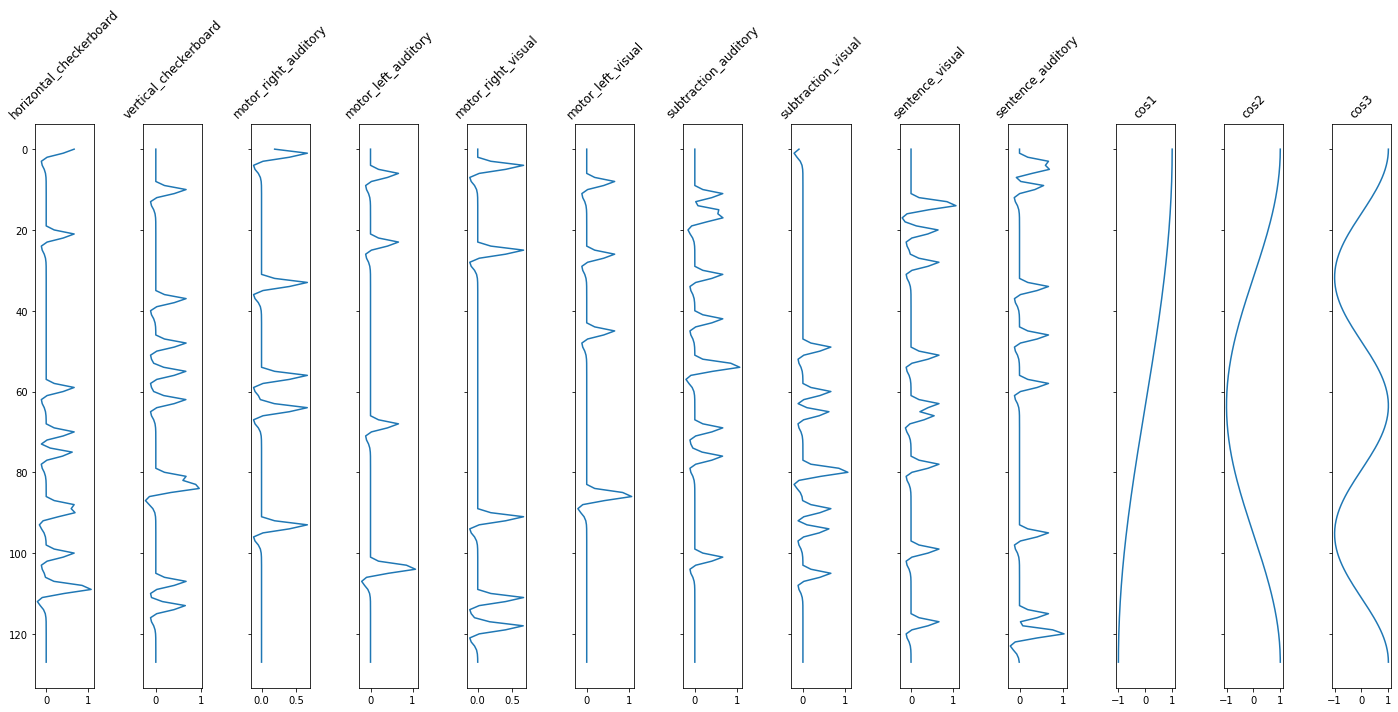

In [14]:
labels_cos = labels + ['cos1','cos2', 'cos3']
plot_design_matrix(design_matrix_cos, labels_cos)

## Intercepts
We almost always want to include an intercept in our model. This will usually reflect the baseline, or the average voxel response during the times that are not being modeled as a regressor. It is important to note that you must have some sparsity to your model, meaning that you can't model every point in time, as this will make your model rank deficient and unestimable.

If you are concatenating runs and modeling them all together, it is recommended to include a separate intercept for each run, but not for the entire model. This means that the average response within a voxel might differ across runs. You can add an intercept by simply creating a new column of ones.

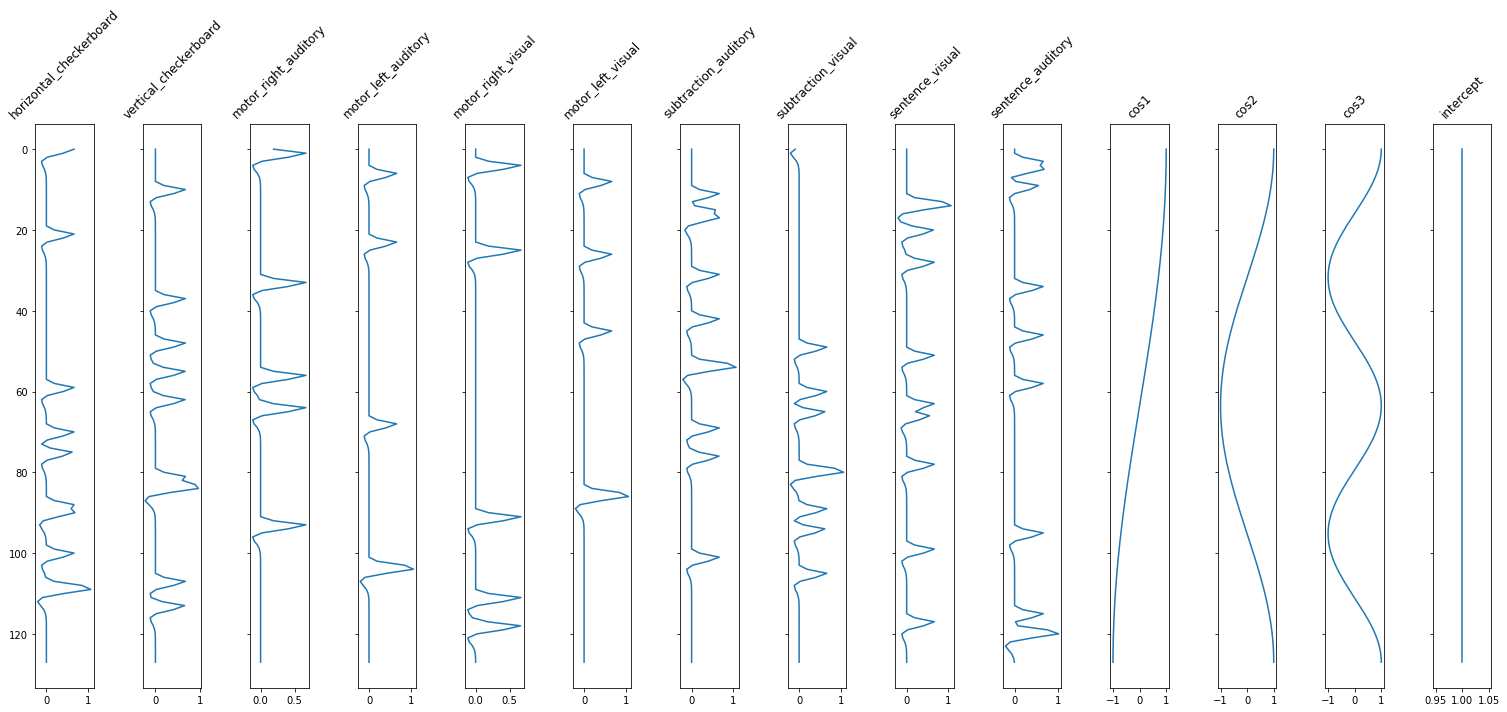

In [15]:
intercept = np.ones((128, 1))
design_matrix_cos_intercept = np.hstack([design_matrix_cos, intercept])
labels_cos_intercept = labels_cos + ['intercept']
plot_design_matrix(design_matrix_cos_intercept, labels_cos_intercept)

## Linear Trends
We also often want to remove any slow drifts in our data.  This might include a linear trend and a quadratic trend. We can also do this with the adding all trends up to an order of 2 (e.g., quadratic).

Notice that these do not appear to be very different from the high pass filter basis set. It's actually okay if there is collinearity in our covariate regressors. Collinearity is only a problem when it correlates with the task regressors as it means that we will not be able to uniquely model the variance. The DCT can occasionally run into edge artifacts, which can be addressed by the linear trend.

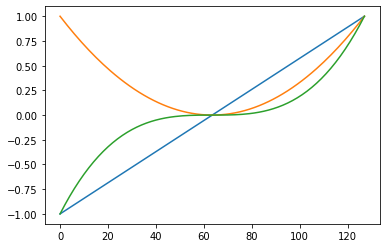

In [16]:
time = np.linspace(-1, 1, 128)

poly1 = time ** 1
plt.plot(poly1)

poly2 = time ** 2
plt.plot(poly2)

poly3 = time ** 3
plt.plot(poly3);

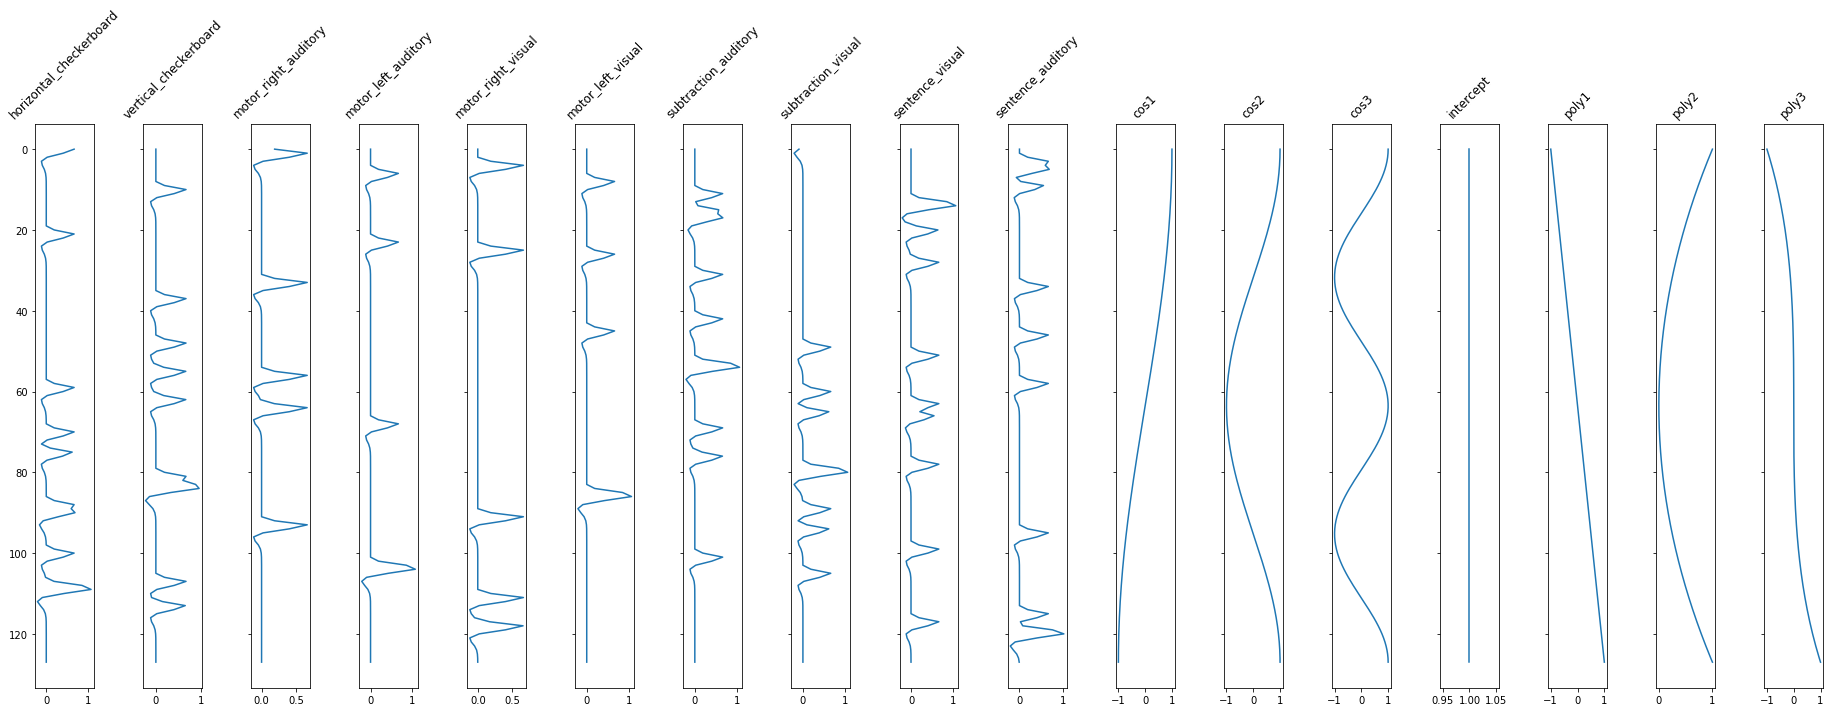

In [17]:
polys = np.array([poly1, poly2, poly3]).T
design_matrix_cos_intercept_polys = np.hstack([design_matrix_cos_intercept, polys])
labels_cos_intercept_polys = labels_cos_intercept + ['poly1','poly2','poly3']
plot_design_matrix(design_matrix_cos_intercept_polys, labels_cos_intercept_polys)

# Exercise: DesignMatrixUtils

So far we have been using a numpy matrix to represent a design matrix. Another way to represent a design matrix is to use a Panda dataframe. In this exercise, you will implement the operations above using a dataframe.

In [18]:
import solutions
import pandas as pd
class DesignMatrixUtils:    
    pass

## create_design_matrix

In [19]:
def create_design_matrix(events, labels, tr, duration):     
    ### BEGIN SOLUTION
    
    design_matrix = np.zeros((duration, len(labels)),int)
    for i in range(0, len(labels)):
        design_vector_i = compute_design_vector(events, i, duration, tr)
        design_matrix[:,i] = design_vector_i.T
    design_matrix = pd.DataFrame(data=design_matrix, columns=labels)
    
    ### END SOLUTION
    return design_matrix

DesignMatrixUtils.create_design_matrix = create_design_matrix

Let's create a toy example with 6 events and 2 event types.

In [20]:
import importlib
importlib.reload(solutions)
events = list(zip([0,4000,8000,12000,16000,20000], [0,1,0,1,0,1]))
labels = ['face', 'object']

Let's create a design matrix with tr=2.4 tr and for a run of 10 slices.

In [21]:
design_matrix = DesignMatrixUtils.create_design_matrix(events, labels, 2.4, 10)
design_matrix

,face,object
0,1,0
1,0,1
2,0,0
3,1,0
4,0,0
5,0,1
6,1,0
7,0,0
8,0,1
9,0,0


It should also work with other scan parameters.

In [22]:
design_matrix = DesignMatrixUtils.create_design_matrix(events, labels, 2, 30)
design_matrix.head()

,face,object
0,1,0
1,0,0
2,0,1
3,0,0
4,1,0


Let's test with a more complex design with five event types and longer duration (i.e., 100000ms)

In [23]:
times = np.linspace(1,100000,40)
types = np.random.randint(0,6,40)
events = list(zip(times, types))
labels = ['face', 'object', 'animal', 'horizontal', 'vertical']

In [24]:
design_matrix1 = DesignMatrixUtils.create_design_matrix(events, labels, 4, 30)
design_matrix1.shape

(30, 5)

In [25]:
design_matrix1.head()

,face,object,animal,horizontal,vertical
0,1,1,0,0,0
1,0,1,0,0,1
2,0,0,1,0,0
3,0,1,0,0,1
4,0,0,0,1,0


In [26]:
design_matrix1.tail()

,face,object,animal,horizontal,vertical
25,0,0,0,0,1
26,0,0,0,0,0
27,0,0,0,0,0
28,0,0,0,0,0
29,0,0,0,0,0


Let's try another scan parameters with `tr=2` and `n_tr=60`

In [27]:
design_matrix2 = DesignMatrixUtils.create_design_matrix(events, labels, 2, 60)
design_matrix2.shape

(60, 5)

In [28]:
design_matrix2.head()

,face,object,animal,horizontal,vertical
0,0,1,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,0,0,1
4,0,0,0,0,0


Let's test `create_design_matrix` function using the localizer dataset.

In [29]:
events, labels = get_localizer_design_data()
design_matrix_localizer = DesignMatrixUtils.create_design_matrix(events, labels, 2.4, 128)
design_matrix_localizer.shape

(128, 10)

In [30]:
design_matrix_localizer.head()

,horizontal_checkerboard,vertical_checkerboard,motor_right_auditory,motor_left_auditory,motor_right_visual,motor_left_visual,subtraction_auditory,subtraction_visual,sentence_visual,sentence_auditory
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


## plot

Now we want to visualize a dataframe-backed design matrix by implementing a `plot` function.

In [31]:
def plot(design_matrix, orientation = 'horizontal'):     
    ### BEGIN SOLUTION
    labels = design_matrix.columns
    m = len(labels)
    times = range(design_matrix.shape[0])

    if orientation == 'vertical':
        f, a = plt.subplots(ncols=m, figsize=(m*1.5, 10), sharey=True)
        for i in range(0, m):        
            label = labels[i]
            a[i].plot(design_matrix[label].to_numpy(), times)
            a[i].set_title(label, fontsize=12, rotation=45)
        plt.gca().invert_yaxis()
    elif orientation == 'horizontal':
        f, a = plt.subplots(nrows=m, sharey=True)
        for i in range(0, m):        
            label = labels[i]
            a[i].plot(times, design_matrix[label].to_numpy())
            a[i].set_title(label, fontsize=12)
    
    plt.tight_layout()
    
    
    ### END SOLUTION
    return

DesignMatrixUtils.plot = plot

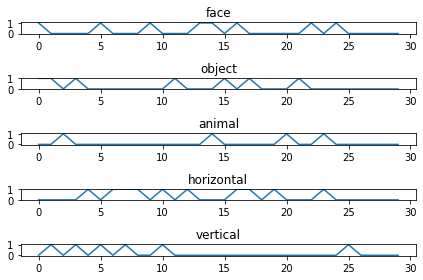

In [32]:
DesignMatrixUtils.plot(design_matrix1, orientation='horizontal')

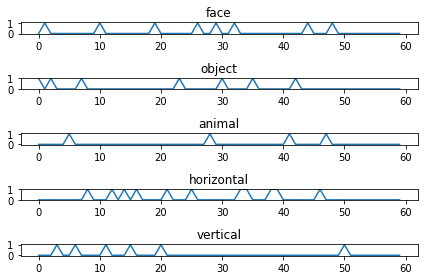

In [33]:
DesignMatrixUtils.plot(design_matrix2, orientation='horizontal')

Since a design matrix is essentially a data frame, we can easily pick a subset of columns to display.

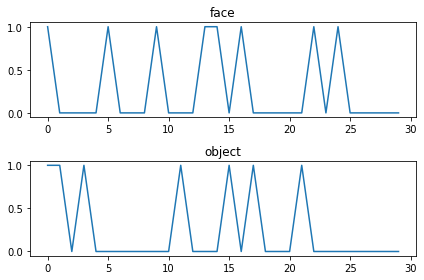

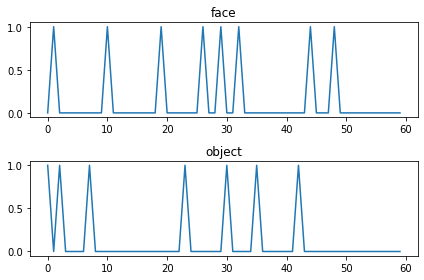

In [34]:
DesignMatrixUtils.plot(design_matrix1[['face','object']], orientation='horizontal')
DesignMatrixUtils.plot(design_matrix2[['face','object']], orientation='horizontal')

The plot function should also display a design matrix vertically.

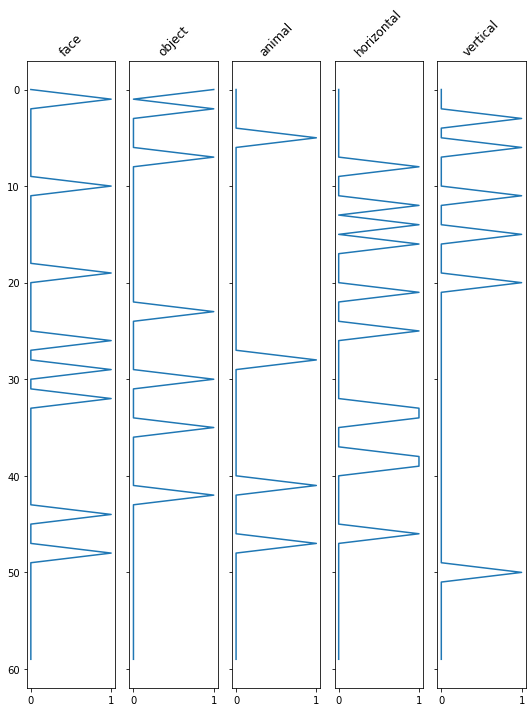

In [35]:
DesignMatrixUtils.plot(design_matrix2, orientation='vertical')

Let's test on the Localizer dataset.

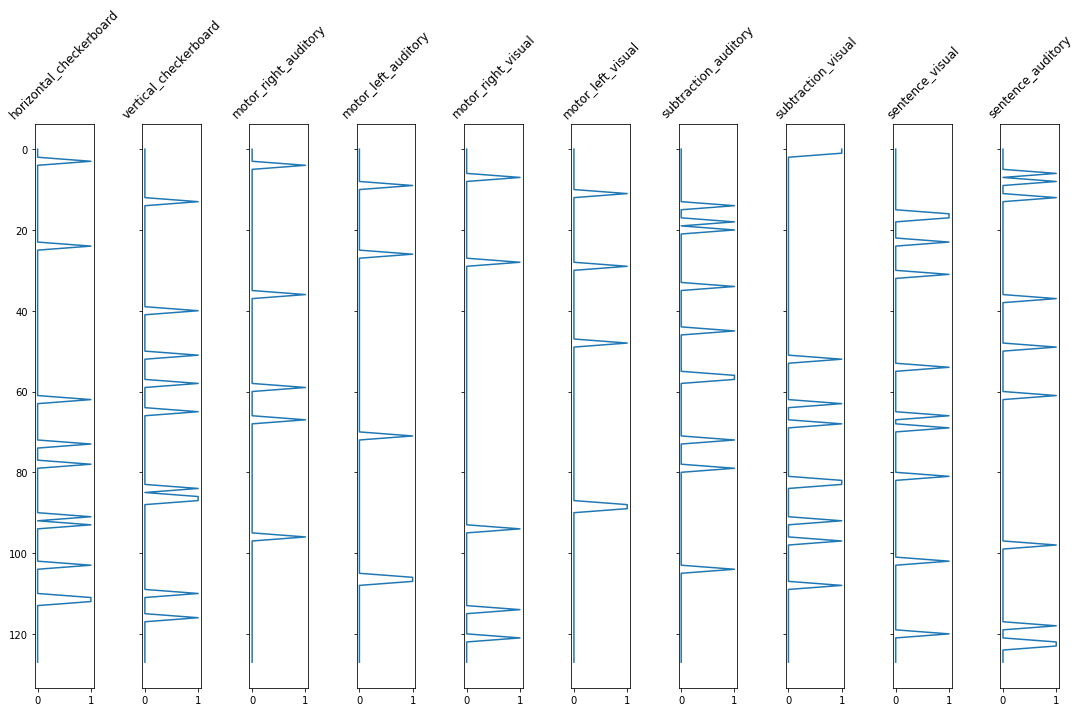

In [36]:
DesignMatrixUtils.plot(design_matrix_localizer, orientation='vertical')

Let's look at only the motor tasks

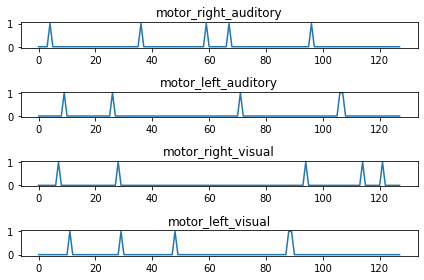

In [37]:
motor_tasks = [col for col in design_matrix_localizer.columns if 'motor' in col]
DesignMatrixUtils.plot(design_matrix_localizer[motor_tasks])

## heatmap

A popular way to look at a design matrix more compactly is to use a heatmap representation. Try to implement it using the heatmap method provided by the seaborn library.

In [38]:
import seaborn as sns
# https://seaborn.pydata.org/generated/seaborn.heatmap.html

def heatmap(design_matrix):     
    ### BEGIN SOLUTION
    
    sns.heatmap(design_matrix, xticklabels=design_matrix.columns)
    ### END SOLUTION
    return

DesignMatrixUtils.heatmap = heatmap

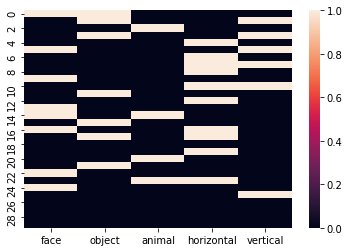

In [39]:
solutions.DesignMatrixUtils.heatmap(design_matrix1)

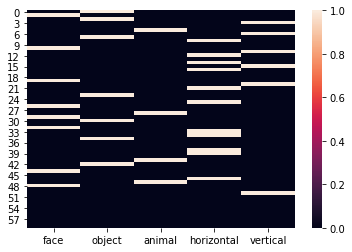

In [40]:
solutions.DesignMatrixUtils.heatmap(design_matrix2)

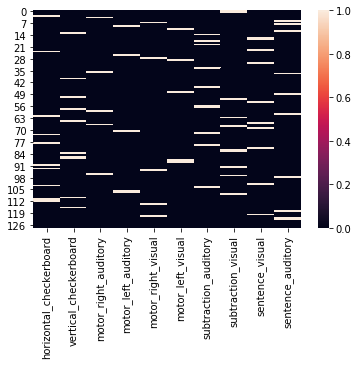

In [41]:
DesignMatrixUtils.heatmap(design_matrix_localizer)

## add_intercept

In [42]:
def add_intercept(design_matrix):     
    ### BEGIN SOLUTION
    design_matrix_new = design_matrix.copy()
    n_rows = design_matrix.shape[0]
    design_matrix_new['intercept'] = np.ones(n_rows)
    return design_matrix_new
    ### END SOLUTION

DesignMatrixUtils.add_intercept = add_intercept

In [43]:
design_matrix1_intercept = DesignMatrixUtils.add_intercept(design_matrix1)
design_matrix1_intercept.head()

,face,object,animal,horizontal,vertical,intercept
0,1,1,0,0,0,1.0
1,0,1,0,0,1,1.0
2,0,0,1,0,0,1.0
3,0,1,0,0,1,1.0
4,0,0,0,1,0,1.0


In [44]:
design_matrix2_intercept = DesignMatrixUtils.add_intercept(design_matrix2)
design_matrix2_intercept.head()

,face,object,animal,horizontal,vertical,intercept
0,0,1,0,0,0,1.0
1,1,0,0,0,0,1.0
2,0,1,0,0,0,1.0
3,0,0,0,0,1,1.0
4,0,0,0,0,0,1.0


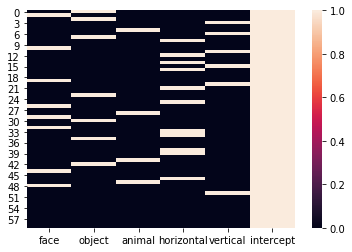

In [45]:
solutions.DesignMatrixUtils.heatmap(design_matrix2_intercept)

## add_poly

In [46]:
def add_poly(design_matrix, degrees=2, flipped=False):     
    ### BEGIN SOLUTION
    design_matrix_new = design_matrix.copy()
    time = np.linspace(-1, 1, design_matrix.shape[0])
    if flipped:
        poly = (1-time) ** degrees
        design_matrix_new['1-poly'+str(degrees)] = poly
    else:
        poly = time ** degrees    
        design_matrix_new['poly'+str(degrees)] = poly
    
    
    
    return design_matrix_new
    ### END SOLUTION
DesignMatrixUtils.add_poly = add_poly

,face,object,animal,horizontal,vertical,poly2
0,1,1,0,0,0,1.000000
1,0,1,0,0,1,0.866825
2,0,0,1,0,0,0.743163
3,0,1,0,0,1,0.629013
4,0,0,0,1,0,0.524376


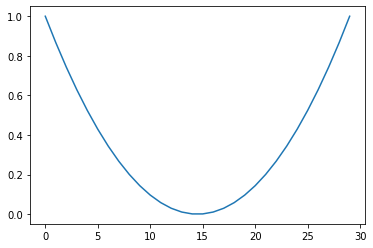

In [47]:
design_matrix1_polys = solutions.DesignMatrixUtils.add_poly(design_matrix1, degrees = 2)
plt.plot(design_matrix1_polys['poly2'].to_numpy())
design_matrix1_polys.head()

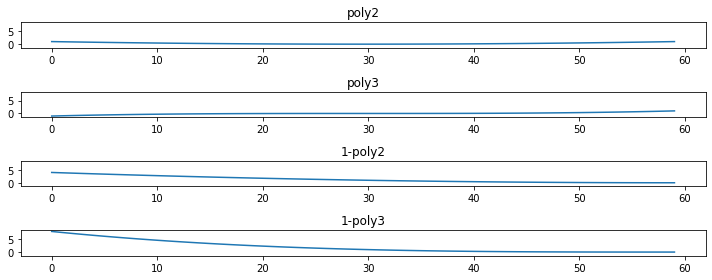

In [48]:
design_matrix2_polys = DesignMatrixUtils.add_poly(design_matrix2, degrees = 2)
design_matrix2_polys = DesignMatrixUtils.add_poly(design_matrix2_polys, degrees = 3)
design_matrix2_polys = DesignMatrixUtils.add_poly(design_matrix2_polys, degrees = 2, flipped = True)
design_matrix2_polys = DesignMatrixUtils.add_poly(design_matrix2_polys, degrees = 3, flipped = True)
solutions.DesignMatrixUtils.plot(design_matrix2_polys[['poly2','poly3','1-poly2','1-poly3']])

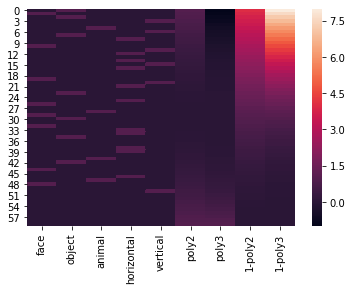

In [49]:
DesignMatrixUtils.heatmap(design_matrix2_polys)

## add_cosine

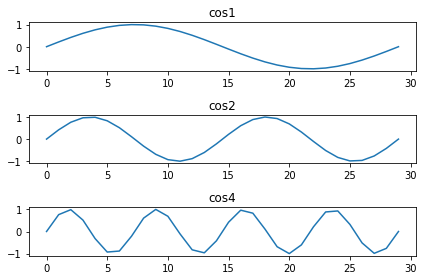

In [50]:

from numpy import sin, pi, arange
def add_cosine(design_matrix, freq, amplitude, phase = 0):     
    ### BEGIN SOLUTION
    
    duration = design_matrix.shape[0]
    
    time = np.linspace(0, 1, duration)
    w = amplitude * sin(2*pi*freq*time + pi*phase)

    copy = design_matrix.copy()
    copy['cos'+str(freq)] = w

    return copy
    ### END SOLUTION
DesignMatrixUtils.add_cosine = add_cosine

design_matrix1_cos = DesignMatrixUtils.add_cosine(design_matrix1, 1, 1, 0)
design_matrix1_cos = DesignMatrixUtils.add_cosine(design_matrix1_cos, 2, 1, 0)
design_matrix1_cos = DesignMatrixUtils.add_cosine(design_matrix1_cos, 4, 1, 0)
DesignMatrixUtils.plot(design_matrix1_cos[['cos1','cos2','cos4']])

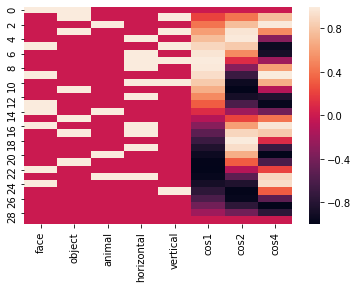

In [51]:
solutions.DesignMatrixUtils.heatmap(design_matrix1_cos)

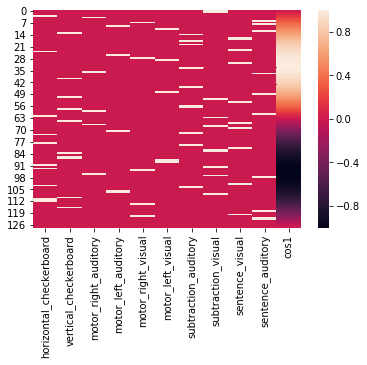

In [52]:
design_matrix_localizer_cos = DesignMatrixUtils.add_cosine(design_matrix_localizer, 1, 1)
solutions.DesignMatrixUtils.heatmap(design_matrix_localizer_cos)

## convolve_hrf

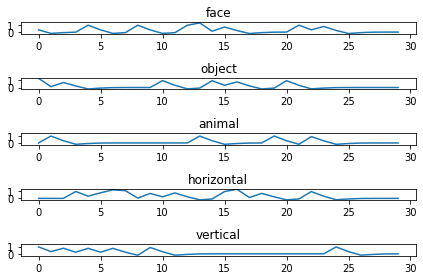

In [53]:
from nltools.external import glover_hrf

def convolve_hrf(design_matrix, tr):     
    ### BEGIN SOLUTION
    design_matrix_new = design_matrix.copy()
    hrf = glover_hrf(tr, oversampling=1) 
    labels = design_matrix.columns
    
    for label in labels:
        design_matrix_new[label] = np.convolve(design_matrix_new[label].to_numpy(), hrf, mode='same') 
        
    return design_matrix_new
    ### END SOLUTION
DesignMatrixUtils.convolve_hrf = convolve_hrf

design_matrix1_hrf = DesignMatrixUtils.convolve_hrf(design_matrix1, 4)
DesignMatrixUtils.plot(design_matrix1_hrf)

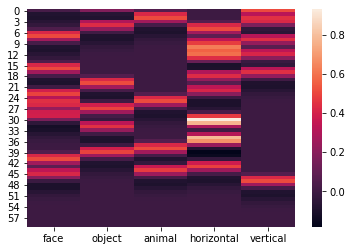

In [54]:
design_matrix2_hrf = DesignMatrixUtils.convolve_hrf(design_matrix2, 2)
DesignMatrixUtils.heatmap(design_matrix2_hrf)

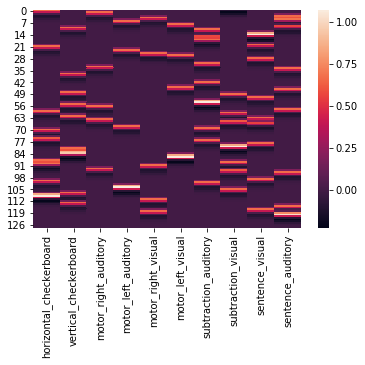

In [55]:
design_matrix_localizer_hrf = DesignMatrixUtils.convolve_hrf(design_matrix_localizer, 2.4)
DesignMatrixUtils.heatmap(design_matrix_localizer_hrf)

## add_many

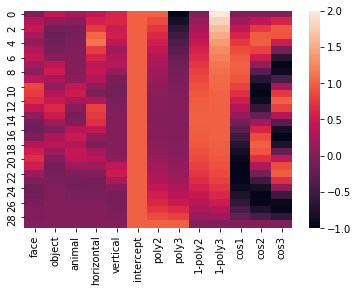

In [56]:
def add_many(design_matrix, funcs = []):     
    ### BEGIN SOLUTION
    design_matrix_new = design_matrix.copy() 
    
    for func in funcs:
        design_matrix_new = func(design_matrix_new)
        
    return design_matrix_new
    
    ### END SOLUTION
DesignMatrixUtils.add_many = add_many
importlib.reload(solutions)
funcs = [
    lambda dm : solutions.DesignMatrixUtils.convolve_hrf(dm, 2),
    lambda dm : solutions.DesignMatrixUtils.add_intercept(dm),
    lambda dm : solutions.DesignMatrixUtils.add_poly(dm, degrees = 2),
    lambda dm : solutions.DesignMatrixUtils.add_poly(dm, degrees = 3),
    lambda dm : solutions.DesignMatrixUtils.add_poly(dm, degrees = 2, flipped = True),
    lambda dm : solutions.DesignMatrixUtils.add_poly(dm, degrees = 3, flipped = True),  
    lambda dm : solutions.DesignMatrixUtils.add_cosine(dm, 1, 1),
    lambda dm : solutions.DesignMatrixUtils.add_cosine(dm, 2, 1),    
    lambda dm : solutions.DesignMatrixUtils.add_cosine(dm, 3, 1),        
]


design_matrix1_a = DesignMatrixUtils.add_many(design_matrix1, funcs)
DesignMatrixUtils.heatmap(design_matrix1_a)

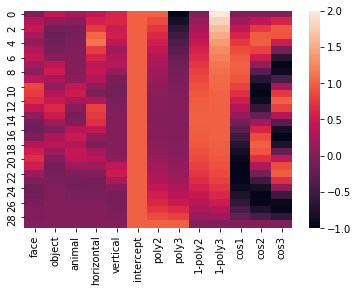

In [57]:
design_matrix1_a = DesignMatrixUtils.add_many(design_matrix1, funcs)
DesignMatrixUtils.heatmap(design_matrix1_a)

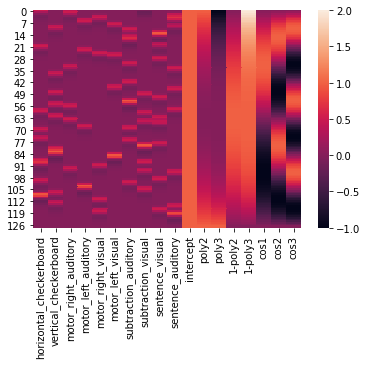

In [58]:
design_matrix_localizer_a = DesignMatrixUtils.add_many(design_matrix_localizer, funcs)
DesignMatrixUtils.heatmap(design_matrix_localizer_a)

# Running GLM using Simulated Functional Data in 1D

Now we can have implemented a set of basic functions to manipulate a design matrix, let' try to apply it to functional brain data. But before we turn to the actual brain data, let's use simulated data for better understanding. We will start with a toy example by simulating functional data as a series of 1D image (as opposed to a 3D volume).

In [59]:
def create_functional_data_1d(size, n_tr):
    data = np.zeros((1, size, n_tr))
    return data

Let's simulate a 1D image of 50 "voxels" for the same number of tr's in `design_matrix1`.

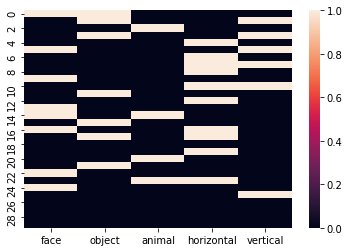

In [60]:
DesignMatrixUtils.heatmap(design_matrix1)

First, let's create blank 1D data with zeros everywhere.

In [61]:
n_tr = design_matrix1.shape[0]
data = create_functional_data_1d(50, n_tr)
data
data.shape

(1, 50, 30)

Let's write a function to help visualize the data. The data represents a sequence of frames, where each frame is a 1D image and there are a total of `n_tr` frames. We can show each 1D image as a row of pixels. But showing all the rows would take too much space. We can instead select only a sample of frames to show. In this case, we select the first 6 frames and another six frames in the middle of the time series.

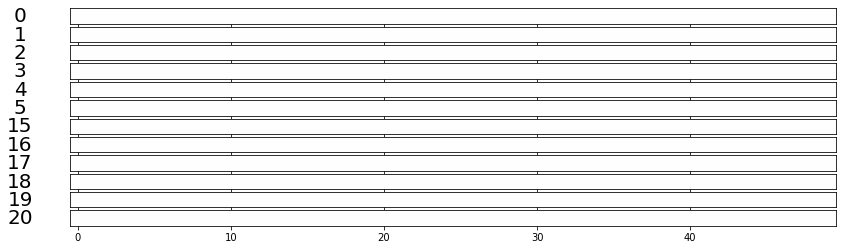

In [62]:
def plot_functional_data_1d(data):
    plt.figure(figsize=(40,4))
    n_tr = data.shape[2]
    c = int(n_tr/2)
    times = [0,1,2,3,4,5] + [c,c+1,c+2,c+3,c+4,c+5]
    m = len(times)
    for i, time in enumerate(times):
        axes = plt.subplot(m,1,i+1)
        plt.imshow(data[:,:,time], vmin=-1, vmax=1, cmap='bwr')
        plt.ylabel(str(time), fontsize=20, rotation=0, labelpad=50, va='center')
        axes.get_yaxis().set_ticks([])
        
plot_functional_data_1d(data)

Suppose there's a voxel that react only to some event types but not to the others. It means the $beta$ values for those event types are high and the $beta$ values for the others are zeros or close to zeros. Thus, in order to simulate how a voxel gets activated in a certain way, we can simply specify a vector of `beta` values and multiply it with a design matrix to get a time series that would model the activation pattern of that voxel.

In [63]:
def generate_time_series(design_matrix, betas):
    y = np.zeros(design_matrix.shape[0])    
    for col, beta in zip(design_matrix.columns, betas):
        y = y + design_matrix[col] * beta
    return y

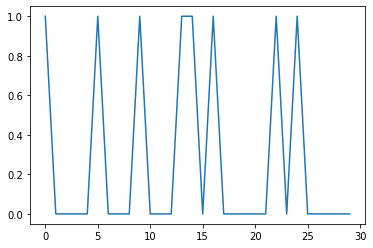

In [64]:
plt.plot(generate_time_series(design_matrix1, [1,0,0,0,0]));

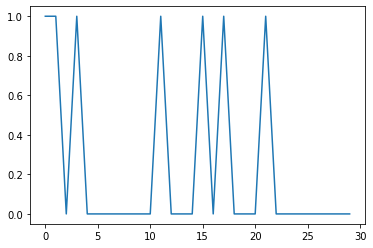

In [65]:
plt.plot(generate_time_series(design_matrix1, [0,1,0,0,0]));

We can simulate voxels that react to only face, object, or animal respectively. This can be done by setting the corresponding $\beta$ to 1

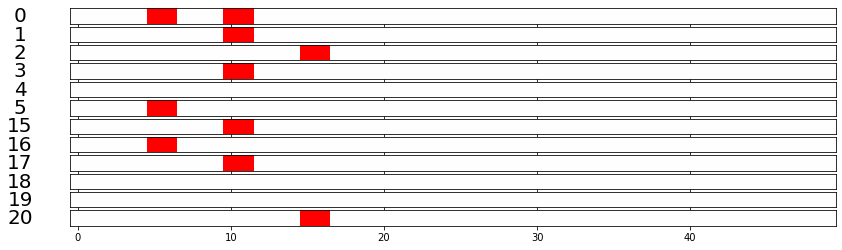

In [66]:
data[:,5:7,:] = generate_time_series(design_matrix1, [1,0,0,0,0])
data[:,10:12,:] = generate_time_series(design_matrix1, [0,1,0,0,0])
data[:,15:17,:] = generate_time_series(design_matrix1, [0,0,1,0,0])

plot_functional_data_1d(data)

We can simulate some voxels that not only react to face, object, and animal images but also to horizontal and vertical patterns. Let's add three groups of voxels that react strongly ($\beta = 1$) to face, object, and animal  and react less strongly ($\beta = 0.5$) to horizontal and vertical patterns.

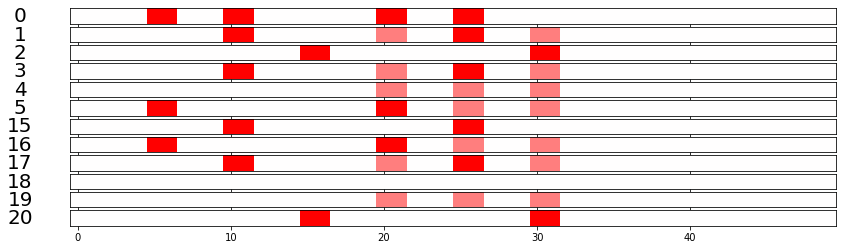

In [67]:
data[:,20:22,:] = generate_time_series(design_matrix1, [1,0,0,0.5,0.5])
data[:,25:27,:] = generate_time_series(design_matrix1, [0,1,0,0.5,0.5])
data[:,30:32,:] = generate_time_series(design_matrix1, [0,0,1,0.5,0.5])

plot_functional_data_1d(data)

Nearby voxels often share similar activation pattern. We can simulate that using a Gaussian filter.

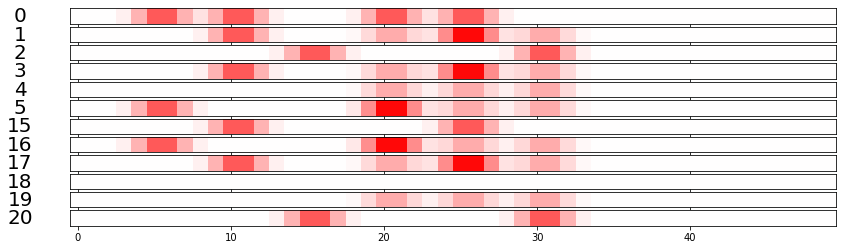

In [68]:
from scipy.ndimage import gaussian_filter1d
data = gaussian_filter1d(data, sigma=1, axis=1)

plot_functional_data_1d(data)

Recall how we compute GLM regission using a function that looks like below.

In [69]:
def estimate_beta(X, Y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)

In [70]:
X = design_matrix1.values

Let's take a look at the beta values we got. Do they match the regions we purposely simulated earlier?

In [71]:
Y = data[0,6,:]
betas = estimate_beta(X,Y)
with np.printoptions(precision=3, suppress=True):
    print(betas)

[ 0.641  0.     0.    -0.    -0.   ]


In [72]:
Y = data[0,11,:]
betas = estimate_beta(X,Y)
with np.printoptions(precision=3, suppress=True):
    print(betas)

[ 0.     0.641  0.     0.    -0.   ]


In [73]:
Y = data[0,21,:]
betas = estimate_beta(X,Y)
with np.printoptions(precision=3, suppress=True):
    print(betas)

[0.641 0.    0.    0.321 0.321]


Now, instead of running `estimate_beta` at an individual location in the image, let's write a loop to perform estimation over the entire image. Note that since we are working with a toy example of 1D image, a single-level loop would suffice.

In [74]:
def compute_beta_map(data, X):
    size = data.shape[1]
    n_regressors = X.shape[1]
    beta_map = np.zeros((1,size,n_regressors))    
    for i in range(size):
        Y = data[0,i,:]
        bs = estimate_beta(X, Y)
        beta_map[0,i,:] = bs
    return beta_map

Note the shape of the resulting map. It should be a series of 1D maps. The size of each map corresponds to the number of voxels (50). And we have five maps, one for each conditions (5).

In [75]:
beta_map = compute_beta_map(data, X)
beta_map.shape

(1, 50, 5)

Pop quiz. If the input is actually a 3D brain volume image, what should be the shape of the output of `compute_beta_map`?

(X,Y,Z, 5)

Let's implement a function to plot the beta map for our 1D toy example. We want to see five plots, each corresponding to an event type.

In [76]:
def plot_beta_map_1d(beta_map, design_matrix):
    plt.figure(figsize=(40,4))
    labels = design_matrix.columns
    m = len(labels)    
    for i, label in enumerate(labels):
        axes = plt.subplot(m,1,i+1)
        plt.imshow(beta_map[:,:,i], cmap='bwr', vmin=-1, vmax=1)
        plt.ylabel(label, fontsize=12, rotation=0, labelpad=40, va='center')
        axes.get_yaxis().set_ticks([])

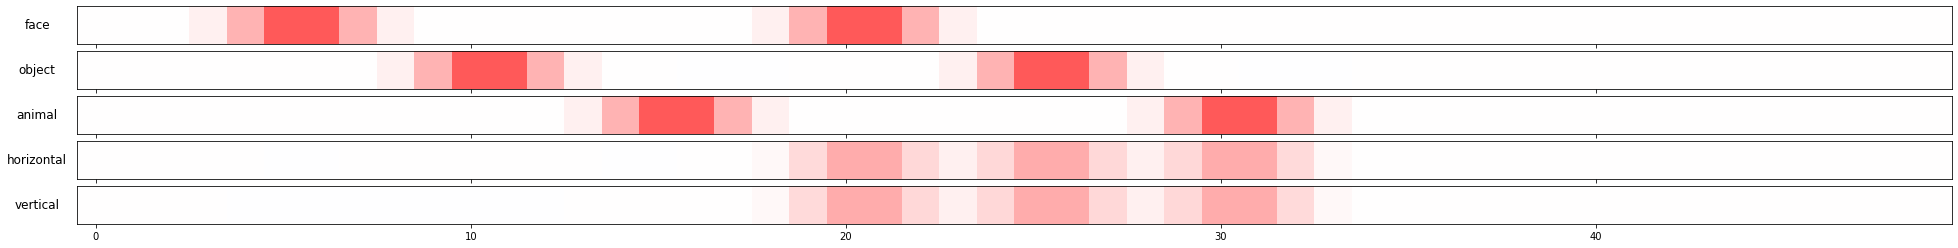

In [77]:
plot_beta_map_1d(beta_map, design_matrix1)

In a fMRI study, we care about contrasts. We basically want to compare one group of conditions to another group of conditions, for example, all visual tasks versus all checkerboard tasks. To look at the contrast, we will take the weighted average of one group of beta maps and subtract from it the weighted average of another group of beta maps. This can be elegantly computed by specifying a vector of the length of the number of betas where we assign positive values to events in one group (e.g., visual) and negative values to events in another group (e.g., checkerboard).

In [78]:
def compute_contrast(beta_map, contrast):    
        
    b = np.squeeze(beta_map)
        
    c = np.array(contrast).T

    cs = np.dot(b,c).T 
    
    # expand cs to a 2D-array so that we can show it using imshow
    cs = np.expand_dims(cs, axis=0)
    return cs

Let's look at just a single event, the face image, by specifying `[1,0,0,0,0]`.

In [79]:
contrast_map = compute_contrast(beta_map, [1,0,0,0,0])
contrast_map.shape

(1, 50)

In [80]:
def show_contrast(beta_map, contrast):
    cs = compute_contrast(beta_map, contrast)
    plt.figure(figsize=(40,2))
    plt.imshow(cs, cmap='gray')

Let's show voxels that react to face images. We see two regions.

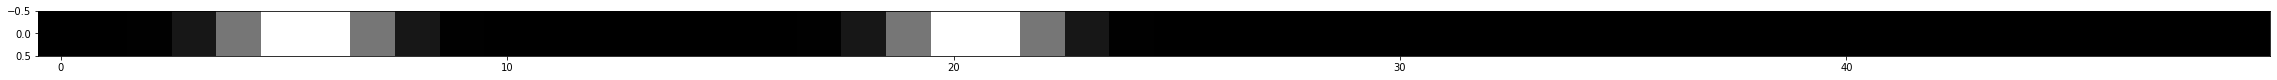

In [81]:
show_contrast(beta_map, [1,0,0,0,0])

How about voxels that react to both face and object images. We can see four voxel regions.

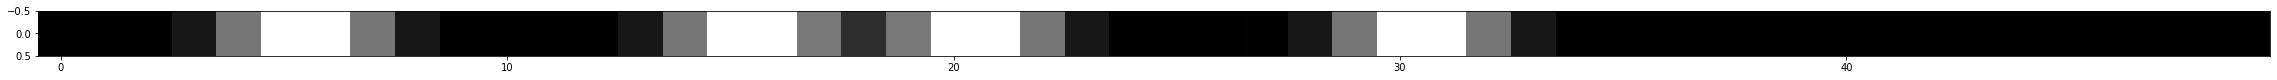

In [82]:
show_contrast(beta_map, [1,0,1,0,0])

face + animal vs. vertical + horizontal 
Instead of four, we see only two regions.

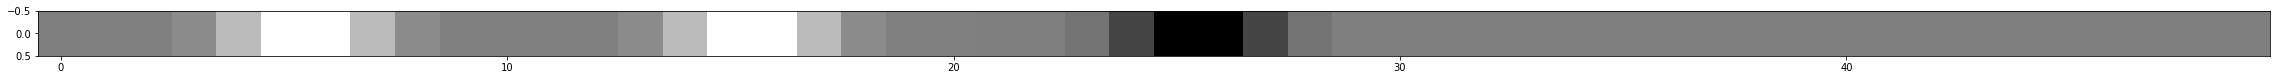

In [83]:
show_contrast(beta_map,[0.5,0,0.5,-0.5,-0.5])

face vs. vertical + horizontal => We see one region highlighted.

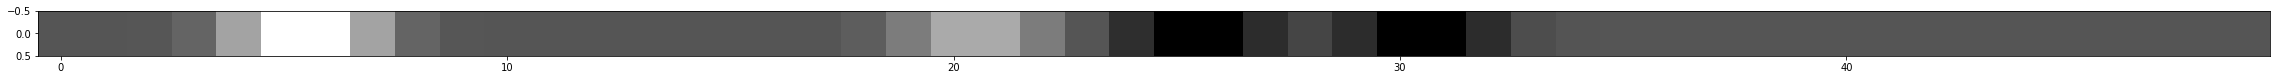

In [84]:
show_contrast(beta_map,[1,0,0,-0.5,-0.5])

# Exercise: Simulation in 2D

Now, to demonstrate your understanding, try to extend the functionality of performing GLM on simulated data to 2D images.

In [137]:
from scipy.ndimage import gaussian_filter
class FunctionalDataSim2D:
    @staticmethod
    def create(height, weight, n_tr):
        data = np.zeros((height, weight, n_tr))
        
        return data
    
    @staticmethod
    def plot_data(data, selected = None):
        plt.figure(figsize=(40,4))
        n_tr = data.shape[2]
        c = int(n_tr/2)
        times = selected
        m = len(times)
        for i, time in enumerate(times):
            axes = plt.subplot(m,1,i+1)
            plt.imshow(data[:,:,time], vmin=-1, vmax=1, cmap='bwr')
            plt.ylabel(str(time), fontsize=20, rotation=0, labelpad=50, va='center')
            axes.get_yaxis().set_ticks([])
    
    @staticmethod
    # mutate 'data' by adding time series calculated from 'design_matrix' and 'betas' at given 'locations'
    def add(data, design_matrix, betas, locations):  
        y = np.zeros(design_matrix.shape[0])    
        for col, beta in zip(design_matrix.columns, betas):
            y = y + design_matrix[col] * beta
        for location in locations:
            data[location[0],location[1],:] = y
        return data
    
    @staticmethod
    def smooth(data):
        data = gaussian_filter1d(data, sigma=1, axis=1, output = data)
        data = gaussian_filter1d(data, sigma=1, axis=0, output = data)
        return data
     
    @staticmethod
    def compute_beta_map(data, X):
        height = data.shape[0]
        width = data.shape[1]
        n_regressors = X.shape[1]
        beta_map = np.zeros((height,width,n_regressors))    
        for i,j in zip(range(height),range(width)):
            Y = data[i,j,:]
            bs = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)
            beta_map[i,j,:] = bs
        return beta_map
    
    @staticmethod
    def plot_beta_map(beta_map, design_matrix):
        plt.figure(figsize=(40,4))
        labels = design_matrix.columns
        m = len(labels)    
        for i, label in enumerate(labels):
            axes = plt.subplot(m,1,i+1)
            plt.imshow(beta_map[:,:,i], cmap='bwr', vmin=-1, vmax=1)
            plt.ylabel(label, fontsize=12, rotation=0, labelpad=40, va='center')
            axes.get_yaxis().set_ticks([])

    @staticmethod
    def show_contrast(beta_map, contrast):
        b = np.squeeze(beta_map)    
        c = np.array(contrast).T
        cs = np.dot(beta_map,c)
        #cs = np.expand_dims(cs, axis=0)
        plt.figure(figsize=(40,2))
        plt.imshow(cs, cmap='gray')
        
    @staticmethod
    def show_contrast_shreshold(beta_map, contrast, shreshold):
        #b = np.squeeze(beta_map)    
        c = np.array(contrast).T
        cs = np.dot(beta_map,c)
        #cs = np.expand_dims(cs, axis=0)
        plt.figure(figsize=(40,2))
        plt.imshow(cs, cmap='gray')

In [138]:
data = FunctionalDataSim2D.create(10,50,30)
data.shape

(10, 50, 30)

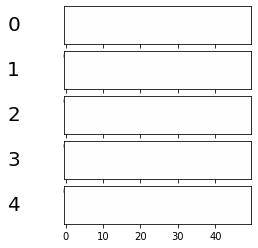

In [139]:
FunctionalDataSim2D.plot_data(data, selected = [0,1,2,3,4])

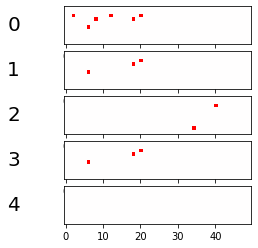

In [140]:
FunctionalDataSim2D.add(data, design_matrix1, [1,0,0,0,0], [(2,2),(3,8),(2,12)])
FunctionalDataSim2D.add(data, design_matrix1, [0,1,0,0,0], [(5,6),(3,18),(2,20)])
FunctionalDataSim2D.add(data, design_matrix1, [0,0,1,0,0], [(8,34),(2,40)])
FunctionalDataSim2D.plot_data(data, selected = [0,1,2,3,4])
#design_matrix1.shape

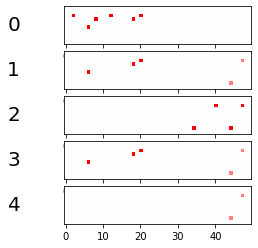

In [141]:
FunctionalDataSim2D.add(data, design_matrix1, [1,0,0,0.5,0.5], [(8,44),(2,47)])
FunctionalDataSim2D.add(data, design_matrix1, [0,0,1,0.5,0.5], [(8,44),(2,47)])
FunctionalDataSim2D.plot_data(data, selected = [0,1,2,3,4])

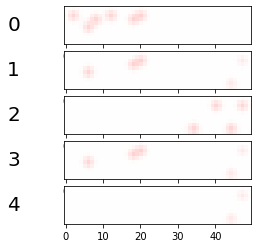

In [142]:
FunctionalDataSim2D.smooth(data)
FunctionalDataSim2D.plot_data(data, selected = [0,1,2,3,4])

In [143]:
beta_map = solutions.FunctionalDataSim2D.compute_beta_map(data, design_matrix1.values)
beta_map.shape

(10, 50, 5)

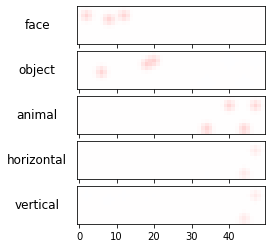

In [144]:
FunctionalDataSim2D.plot_beta_map(beta_map, design_matrix1)

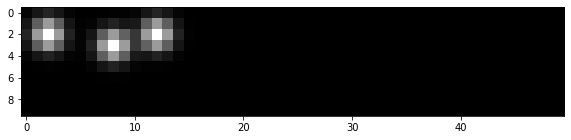

In [146]:
FunctionalDataSim2D.show_contrast(beta_map, [1,0,0,0,0])

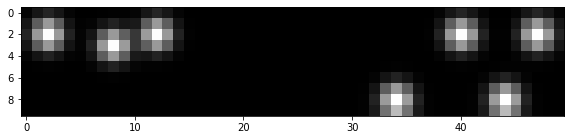

In [147]:
FunctionalDataSim2D.show_contrast(beta_map, [0.5,0,0.5,0,0])

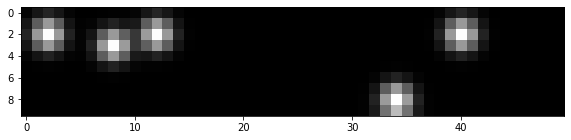

In [148]:
FunctionalDataSim2D.show_contrast(beta_map, [0.25,0,0.25,-0.25,-0.25])

In [ ]:
def get_contrast_by_names(regressor_names, group1_name, group2_name): 
    # with the names, defines the contrasts and show contrast
    